In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import nltk
import os
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from gensim.models import FastText
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
import gdown
#Mount the google drive into google collab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Direct link to the file
link = 'https://drive.google.com/uc?id=1CnX7WJJO1IuGt9hoEZPDkp81P670Sger'


# Download the file
output_file = 'training_data.csv'
gdown.download(link, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CnX7WJJO1IuGt9hoEZPDkp81P670Sger
To: /content/training_data.csv
100%|██████████| 2.70M/2.70M [00:00<00:00, 23.3MB/s]


'training_data.csv'

In [5]:
#Read the training set
training_df = pd.read_csv('/content/training_data.csv',sep='\t', header=None)

#Add meaningful column names
training_df.columns = ['fake_news_flag','news_content']

#Re-order the columns
training_df = training_df[['news_content','fake_news_flag']]

training_df

,news_content,fake_news_flag
0,donald trump sends out embarrassing new year‚s...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama‚s name ...,0
4,pope francis just called out donald trump duri...,0
...,...,...
34147,tears in rain as thais gather for late king's ...,1
34148,pyongyang university needs non-u.s. teachers a...,1
34149,philippine president duterte to visit japan ah...,1
34150,japan's abe may have won election\tbut many do...,1


In [6]:
def fn_clean_text(texts):
    docs = nlp.pipe(texts)  # Batch processing
    cleaned_texts = [
        ' '.join([token.text for token in doc if not token.is_stop])
        for doc in docs
    ]
    return cleaned_texts

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Convert the case to lower
training_df['news_content'] = training_df['news_content'].str.lower()


# Apply the cleaning function
training_df['news_content_clean'] = fn_clean_text(training_df['news_content'])

# Remove punctuation using regex
training_df['news_content_clean'] = training_df['news_content_clean'].str.replace(r'[^\w\s]', '', regex=True)


#Display the sample
training_df.head()


,news_content,fake_news_flag,news_content_clean
0,donald trump sends out embarrassing new year‚s...,0,donald trump sends embarrassing new years eve ...
1,drunk bragging trump staffer started russian c...,0,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes an internet joke ...,0,sheriff david clarke internet joke threatening...
3,trump is so obsessed he even has obama‚s name ...,0,trump obsessed obamas coded website images
4,pope francis just called out donald trump duri...,0,pope francis called donald trump christmas speech


In [7]:
for i in range(5):
    print("Original : {}".format(training_df.iloc[i,0]))
    print("Cleaned : {}\n".format(training_df.iloc[i,2]))

Original : donald trump sends out embarrassing new year‚s eve message; this is disturbing
Cleaned : donald trump sends embarrassing new years eve message  disturbing

Original : drunk bragging trump staffer started russian collusion investigation
Cleaned : drunk bragging trump staffer started russian collusion investigation

Original : sheriff david clarke becomes an internet joke for threatening to poke people ‚in the eye‚
Cleaned : sheriff david clarke internet joke threatening poke people  eye 

Original : trump is so obsessed he even has obama‚s name coded into his website (images)
Cleaned : trump obsessed obamas coded website  images 

Original : pope francis just called out donald trump during his christmas speech
Cleaned : pope francis called donald trump christmas speech



# Data Split

In [ ]:
# Assuming `training_df` has 'news_content_clean' and 'label' columns
X = training_df['news_content_clean']
y = training_df['fake_news_flag']

# Train-Test Split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, training_df.index, test_size=0.3, random_state=42)
print("Training Size : {}".format(X_train.shape[0]))
print("Test Size : {}".format(X_test.shape[0]))

Training Size : 23906
Test Size : 10246


# Text Vectorizer - TF-IDF vs FastText


## TF-IDF

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.fit_transform(X_test)

## FastText

In [ ]:
# Tokenize train and test sets separately to avoid leakage
train_corpus = X_train.apply(str.split).tolist()
test_corpus = X_test.apply(str.split).tolist()

#Train FastText model on the training data only
fasttext_model = FastText(sentences=train_corpus, vector_size=100, window=5, min_count=1, epochs=10)

# Step 4: Create document embeddings
def get_document_embedding_fasttext(doc, model):
    """
    Generate a document embedding by averaging word vectors.
    If a word is not in the model, it is ignored.
    """
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Transform train and test sets into embeddings
X_train_embeddings = np.array([get_document_embedding_fasttext(doc, fasttext_model) for doc in train_corpus])
X_test_embeddings = np.array([get_document_embedding_fasttext(doc, fasttext_model) for doc in test_corpus])

## Testing Different Models with these vectorizers

## Logistic Regression

In [ ]:
# Logistic Regresssion with TF-IDF
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = lr.predict(X_test_tfidf)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred))

# Logistic Regresssion with FastText Embeddings
lr = LogisticRegression(random_state=42)
lr.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = lr.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print("FastText Accuracy:", accuracy)

TF-IDF Accuracy: 0.5772008588717549
FastText Accuracy: 0.8850283037282842


## Random Forest

In [ ]:
# Random Forest with TF-IDF
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_tfidf)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred))

# Random Forest with FastText Embeddings
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print("FastText Accuracy:", accuracy)

TF-IDF Accuracy: 0.5582666406402499
FastText Accuracy: 0.9011321491313683


## Gradient Boosting

In [ ]:
# Gradient Boosting with TF-IDF
gb = GradientBoostingClassifier(n_estimators=500, random_state=42)
gb.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = gb.predict(X_test_tfidf)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred))

# Gradient Boosting with FastText Embeddings
gb = GradientBoostingClassifier(n_estimators=500, random_state=42)
gb.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = gb.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print("FastText Accuracy:", accuracy)

TF-IDF Accuracy: 0.5638297872340425
FastText Accuracy: 0.8977161819246535


## XGBoost

In [ ]:
# XGBoost with TF-IDF
xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, random_state=42, reg_lambda=1)
xgb.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = xgb.predict(X_test_tfidf)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred))

xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, random_state=42, reg_lambda=1)
xgb.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = xgb.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print("FastText Accuracy:", accuracy)

TF-IDF Accuracy: 0.556802654694515
FastText Accuracy: 0.9031817294553972


## LGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(n_estimators=500, learning_rate = 0.1, random_state=42, reg_lambda=1, verbose=0)
lgb.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = lgb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print("TF_IDF Accuracy:", accuracy)

lgb = LGBMClassifier(n_estimators=500, learning_rate = 0.1, random_state=42, reg_lambda=1, verbose=0)
lgb.fit(X_train_embeddings, y_train)

# Evaluate the model
y_pred = lgb.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print("FastText Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


TF_IDF Accuracy: 0.5862775717353114


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


FastText Accuracy: 0.9037673238336912


# Best Classifier - LightGBM

In [ ]:
#Final Tuned Classical Model
lgb = LGBMClassifier(n_estimators=500, learning_rate = 0.1, random_state=42, reg_lambda=1, verbose=0)

lgb.fit(X_train_embeddings, y_train)

#Predict
y_pred = lgb.predict(X_test_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Model Accuracy: 0.9037673238336912
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      5295
           1       0.91      0.89      0.90      4951

    accuracy                           0.90     10246
   macro avg       0.90      0.90      0.90     10246
weighted avg       0.90      0.90      0.90     10246



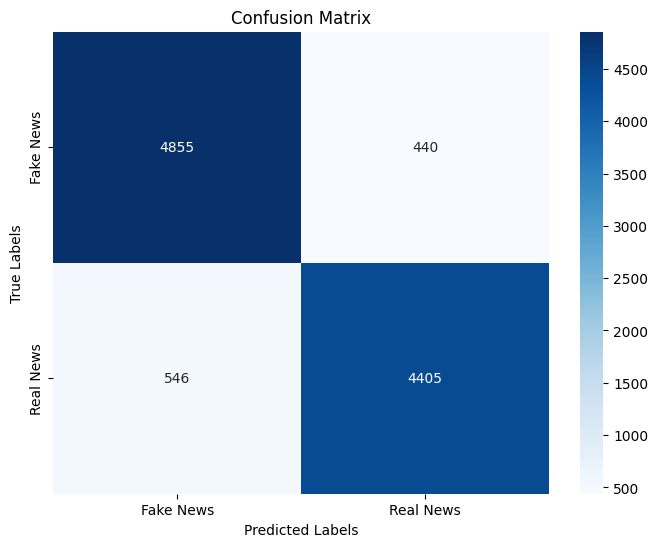

In [ ]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
cf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

class_labels = ['Fake News', 'Real News']

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## Pre-trained Models

## Model - distilbert-base-uncased-finetuned-fake-news

In [ ]:
from transformers import pipeline
MODEL = "jaranohaal/distilbert-base-uncased-finetuned-fake-news"
clf = pipeline("text-classification", model=MODEL, tokenizer=MODEL)

#Predict using pre-trained model
y_pred = clf(X_test.to_list())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
#Convert the dataset
predictions = pd.DataFrame(y_pred)
predictions['predicted_label'] =  predictions['label'].apply(lambda x:int(x[-1]))
predictions = predictions[['predicted_label','score']]


#Merge the results
test_results = pd.DataFrame({'news_content': X_test,
                             'true_label': y_test}).reset_index(drop=True)

test_results = pd.concat([test_results,predictions],axis=1)

test_results

,news_content,true_label,predicted_label,score
0,release house tax bill delayed thursday,1,1,0.994471
1,confusion trump talks foreign leader,1,1,0.999781
2,obama says chinese led trade deal shows need ...,1,1,0.999608
3,pastor turned teacher beat students,0,1,0.680943
4,breaking south carolina senate caves votes r...,0,1,0.843718
...,...,...,...,...
10241,ag sessions persuaded trump end daca,0,1,0.999047
10242,trumps deplorable fans attack mom disabled dau...,0,1,0.987354
10243,white house pressures big corn meet us biofue...,1,1,0.999353
10244,creepy trump promised teenage ivanka hed date...,0,0,0.999115


Model Accuracy: 0.742045676361507
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.56      0.69      5295
           1       0.67      0.93      0.78      4951

    accuracy                           0.74     10246
   macro avg       0.78      0.75      0.74     10246
weighted avg       0.79      0.74      0.73     10246



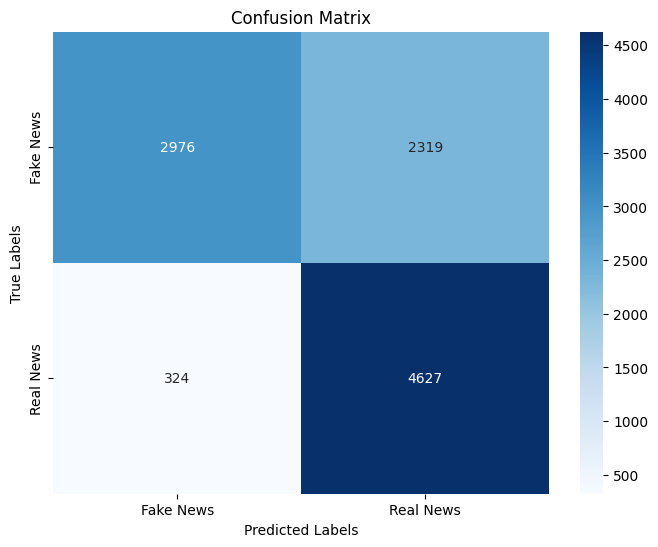

In [ ]:
# Evaluate
y_test = test_results['true_label']
y_pred = test_results['predicted_label']

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
cf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

class_labels = ['Fake News', 'Real News']

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## Model - Fake-News-Bert-Detect

In [ ]:
MODEL = "jy46604790/Fake-News-Bert-Detect"
clf = pipeline("text-classification", model=MODEL, tokenizer=MODEL)

#Predict using pre-trained model
y_pred = clf(X_test.to_list())

Device set to use cpu


In [ ]:
#Convert the dataset
predictions = pd.DataFrame(y_pred)
predictions['predicted_label'] =  predictions['label'].apply(lambda x:int(x[-1]))
predictions = predictions[['predicted_label','score']]


#Merge the results
test_results = pd.DataFrame({'news_content': X_test,
                             'true_label': y_test}).reset_index(drop=True)

test_results = pd.concat([test_results,predictions],axis=1)

test_results

,news_content,true_label,predicted_label,score
0,release house tax bill delayed thursday,1,0,0.993525
1,confusion trump talks foreign leader,1,0,0.997084
2,obama says chinese led trade deal shows need ...,1,0,0.951884
3,pastor turned teacher beat students,0,0,0.997792
4,breaking south carolina senate caves votes r...,0,0,0.998085
...,...,...,...,...
10241,ag sessions persuaded trump end daca,0,0,0.998898
10242,trumps deplorable fans attack mom disabled dau...,0,0,0.998398
10243,white house pressures big corn meet us biofue...,1,0,0.997495
10244,creepy trump promised teenage ivanka hed date...,0,0,0.998519


Model Accuracy: 0.592133515518251
Classification Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.72      5295
           1       0.98      0.16      0.27      4951

    accuracy                           0.59     10246
   macro avg       0.77      0.58      0.50     10246
weighted avg       0.76      0.59      0.50     10246



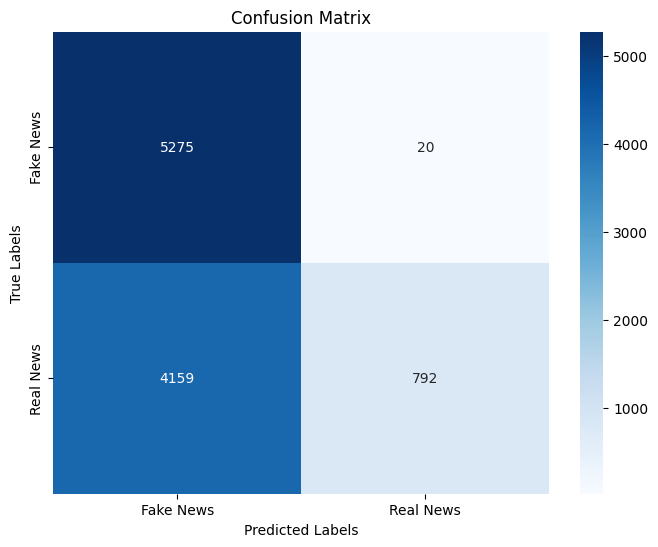

In [ ]:
# Evaluate
y_test = test_results['true_label']
y_pred = test_results['predicted_label']

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
cf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

class_labels = ['Fake News', 'Real News']

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Model - News_Detection

In [ ]:
from transformers import pipeline
MODEL = "Falah/News_Detection"
clf = pipeline("text-classification", model=MODEL, tokenizer=MODEL)

#Predict using pre-trained model
y_pred = clf(X_test.to_list())

Device set to use cpu


In [ ]:
#Convert the dataset
predictions = pd.DataFrame(y_pred)
predictions['predicted_label'] =  predictions['label'].apply(lambda x:int(x[-1]))
predictions = predictions[['predicted_label','score']]


#Merge the results
test_results = pd.DataFrame({'news_content': X_test,
                             'true_label': y_test}).reset_index(drop=True)

test_results = pd.concat([test_results,predictions],axis=1)

test_results

,news_content,true_label,predicted_label,score
0,release house tax bill delayed thursday,1,0,0.659379
1,confusion trump talks foreign leader,1,0,0.738415
2,obama says chinese led trade deal shows need ...,1,1,0.891501
3,pastor turned teacher beat students,0,0,0.922101
4,breaking south carolina senate caves votes r...,0,0,0.689023
...,...,...,...,...
10241,ag sessions persuaded trump end daca,0,0,0.897072
10242,trumps deplorable fans attack mom disabled dau...,0,0,0.903909
10243,white house pressures big corn meet us biofue...,1,0,0.513628
10244,creepy trump promised teenage ivanka hed date...,0,0,0.890350


Model Accuracy: 0.4760882295529963
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.64      0.56      5295
           1       0.44      0.31      0.36      4951

    accuracy                           0.48     10246
   macro avg       0.47      0.47      0.46     10246
weighted avg       0.47      0.48      0.46     10246



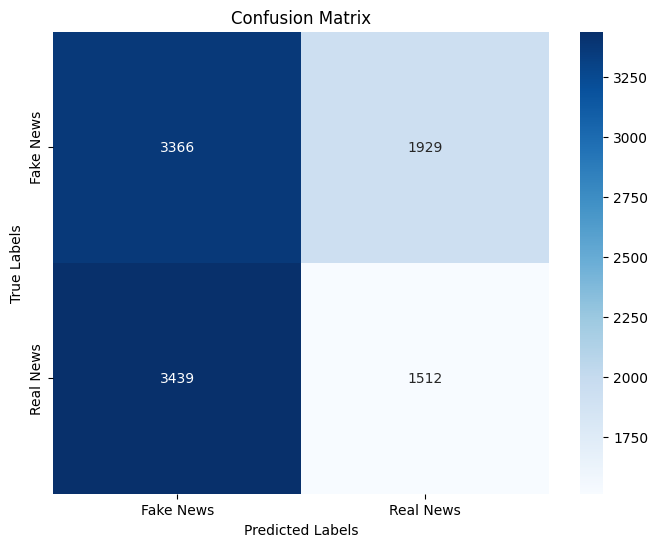

In [ ]:
# Evaluate
y_test = test_results['true_label']
y_pred = test_results['predicted_label']

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
cf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

class_labels = ['Fake News', 'Real News']

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Sentiment Analysis

In [9]:
#pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 65.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [8]:
fake_news_df = training_df['news_content_clean'][training_df['fake_news_flag'] == 0]
real_news_df = training_df['news_content_clean'][training_df['fake_news_flag'] == 1]

In [15]:
from transformers import pipeline
import torch


# Load the model
classifier = pipeline(
    "text-classification",
    model="cirimus/modernbert-large-go-emotions",
    top_k=True
)

Device set to use cuda:0


In [16]:
predictions_fake = classifier(fake_news_df.tolist())
predictions_real = classifier(real_news_df.tolist())

In [25]:
def fn_check_emotion_strength(predictions):

      # Flatten the list of lists into a single list of dictionaries
      flattened_data = [item for sublist in predictions for item in sublist]

      #Emotions Dataframe
      emotions_df = pd.DataFrame(flattened_data)

      emotions_cnt = emotions_df.label.value_counts().reset_index()

      emotions_grp_df = emotions_df.groupby('label').mean().reset_index()

      #Merge two dataframes
      emotions_grp_df = pd.merge(emotions_grp_df, emotions_cnt, on='label')

      # Sorting the DataFrame by score in descending order
      emotions_grp_df = emotions_grp_df.sort_values(by='score', ascending=False)

      return emotions_grp_df


In [26]:
emotions_fake_df = fn_check_emotion_strength(predictions_fake)
emotions_real_df = fn_check_emotion_strength(predictions_real)

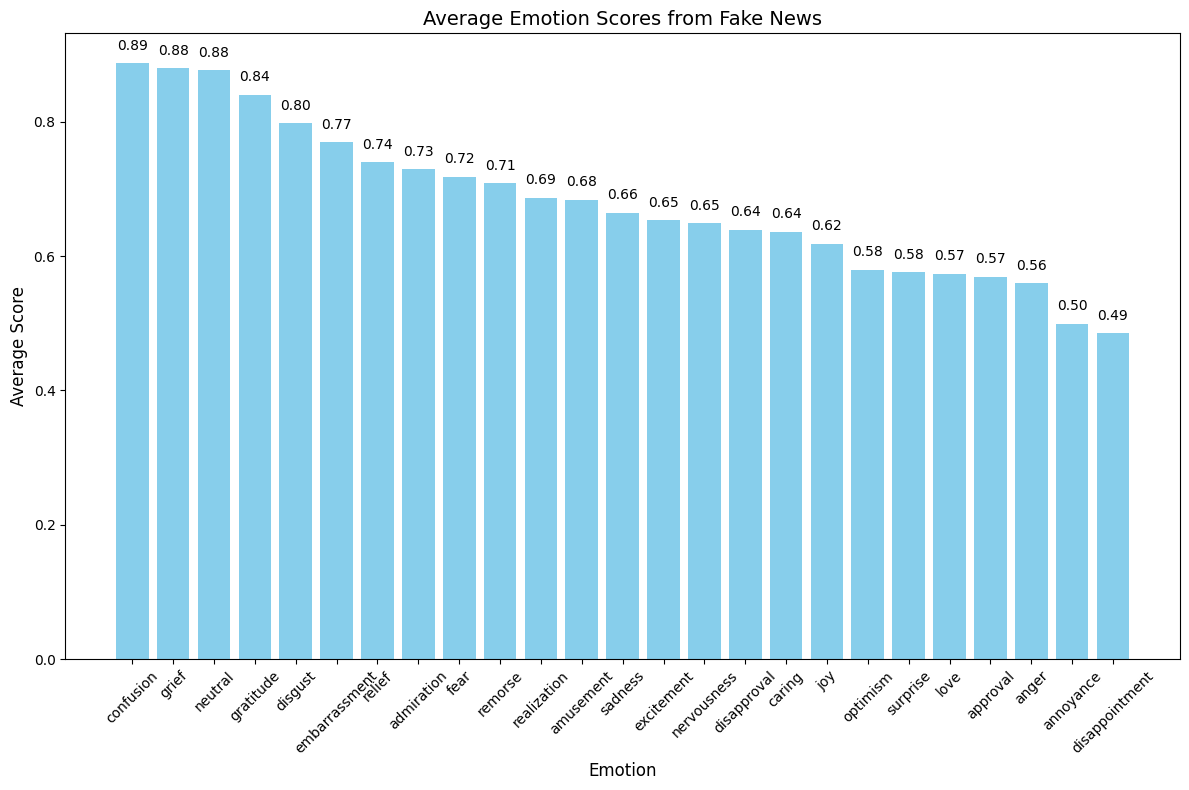

In [27]:
import matplotlib.pyplot as plt


# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.bar(emotions_fake_df['label'], emotions_fake_df['score'], color='skyblue')

# Adding annotations to the bars
for i, value in enumerate(emotions_fake_df['score']):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=10)

# Adding title and labels
plt.title('Average Emotion Scores from Fake News', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Average Score', fontsize=12)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=10)

# Adjusting layout for better spacing
plt.tight_layout()

# Displaying the plot
plt.show()


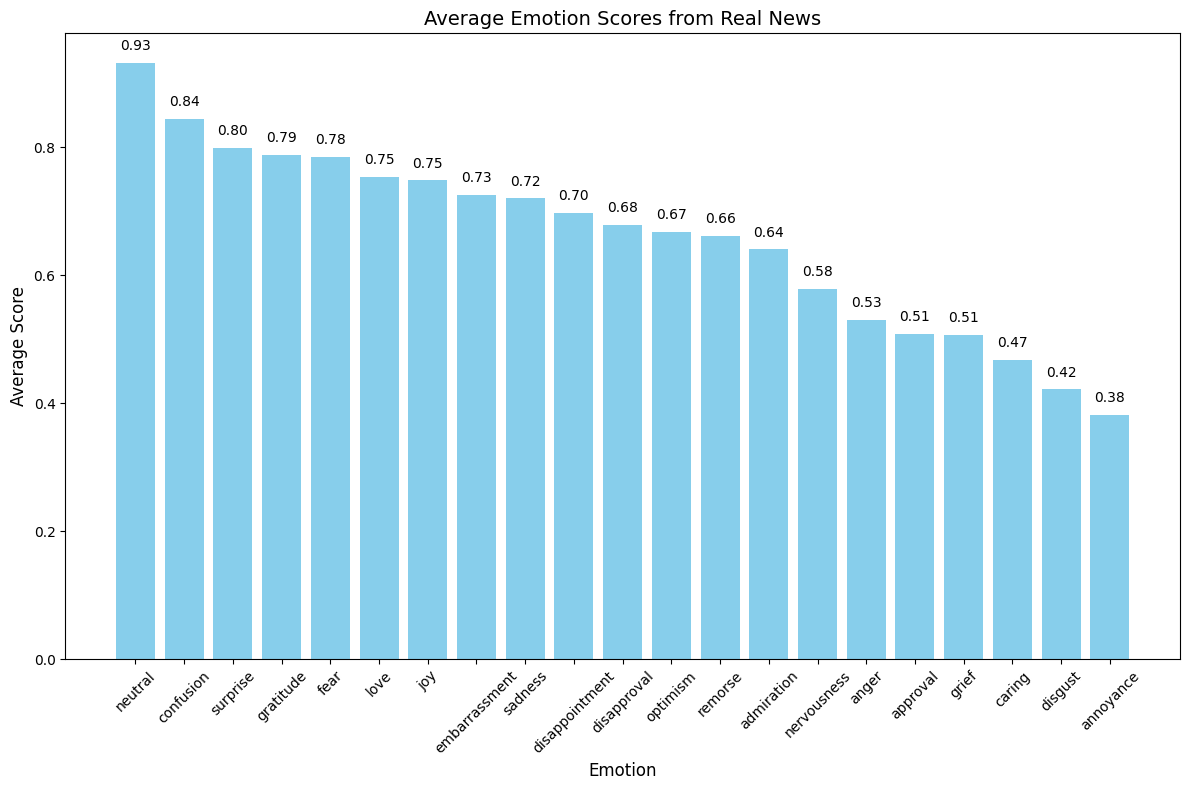

In [28]:
# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.bar(emotions_real_df['label'], emotions_real_df['score'], color='skyblue')

# Adding annotations to the bars
for i, value in enumerate(emotions_real_df['score']):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=10)

# Adding title and labels
plt.title('Average Emotion Scores from Real News', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Average Score', fontsize=12)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=10)

# Adjusting layout for better spacing
plt.tight_layout()

# Displaying the plot
plt.show()


In [29]:
emotions_fake_df.to_csv('emotions_fake_df.csv', index=False)
emotions_real_df.to_csv('emotions_real_df.csv', index=False)

In [31]:
emotions_real_df.sort_values(by='count', ascending=False)

,label,score,count
16,neutral,0.931725,16396
17,optimism,0.667448,34
18,remorse,0.661116,23
0,admiration,0.640553,20
11,gratitude,0.788758,17
20,surprise,0.799208,15
6,disappointment,0.697100,13
5,confusion,0.844596,12
15,nervousness,0.579102,10
7,disapproval,0.678814,7


In [32]:
emotions_fake_df.sort_values(by='count', ascending=False)

,label,score,count
18,neutral,0.876830,16016
1,amusement,0.683779,375
0,admiration,0.728767,326
24,surprise,0.575511,193
9,disgust,0.797924,124
12,fear,0.718015,84
10,embarrassment,0.769749,76
13,gratitude,0.840236,70
3,annoyance,0.499173,57
2,anger,0.559418,47
